<a href="https://colab.research.google.com/github/avionerman/machine_learning_2025/blob/main/competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

#pd.set_option('display.max_columns', 100)

# Data Loading

In [134]:
# load training features and ground truth
train_features = pd.read_csv('train_hh_features.csv')
train_gt = pd.read_csv('train_hh_gt.csv')

# load test features
test_features = pd.read_csv('test_hh_features.csv')

# load poverty rate ground truth
train_rates_gt = pd.read_csv('train_rates_gt.csv')

print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Ground truth shape: {train_gt.shape}")

Training features shape: (104234, 88)
Test features shape: (103023, 88)
Ground truth shape: (104234, 3)


# Merging training features & targets

In [135]:
# having features and targets in diff dfs has no logic at all
train = train_features.merge(train_gt, on=['survey_id', 'hhid'], how='left')

print(f"Merged training shape: {train.shape}")
print(f"\nTarget variable (cons_ppp17) stats:")
print(train['cons_ppp17'].describe())

Merged training shape: (104234, 89)

Target variable (cons_ppp17) stats:
count    104234.000000
mean         11.555229
std          10.034225
min           0.359563
25%           5.439294
50%           8.774002
75%          14.216931
max         236.115680
Name: cons_ppp17, dtype: float64


# Checking missing values

In [136]:
# check total missing values
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)

# check only columns with missing values
missing_df = pd.DataFrame({
    'missing count': missing,
    'missing ratio %': missing_pct
})
missing_df = missing_df[missing_df['missing count'] > 0].sort_values('missing ratio %', ascending=False)

print("total column with missing values:")
print(missing_df)

total column with missing values:
                 missing count  missing ratio %
sector1d                 14129            13.56
dweltyp                   1206             1.16
utl_exp_ppp17               85             0.08
consumed5000                66             0.06
consumed4300                52             0.05
consumed4500                54             0.05
consumed4600                56             0.05
consumed4800                56             0.05
consumed4400                52             0.05
consumed4900                56             0.05
consumed4700                52             0.05
employed                    45             0.04
consumed3900                40             0.04
consumed4000                38             0.04
consumed4100                40             0.04
consumed4200                44             0.04
consumed3800                35             0.03
consumed3700                29             0.03
consumed3300                20             0.02
consum

# SectorID - Unemployment correlation check

In [137]:
print("Employment status when sector1d is missing:")
print(train[train['sector1d'].isnull()]['employed'].value_counts())

print("\nEmployment status when sector1d is NOT missing:")
print(train[train['sector1d'].notna()]['employed'].value_counts())

Employment status when sector1d is missing:
employed
Not employed    14084
Name: count, dtype: int64

Employment status when sector1d is NOT missing:
employed
Employed    90105
Name: count, dtype: int64


Observation:



*   we have 14.084 not eployed household heads with sector1d missing and
*   we have 90.105 employed household heads with the sector1d having a value

Thus, this is not just missing data, it means that is logically missing, since you can't have an employment sector and being unemployed at the same time.


# Handling missing values

In [138]:
# fill sector1d for the unemployed household heads

train['sector1d'] = train['sector1d'].fillna('Not employed')
test_features['sector1d'] = test_features['sector1d'].fillna('Not employed')

print("sector1d missing after fix:")
print(f"  Train: {train['sector1d'].isnull().sum()}")
print(f"  Test: {test_features['sector1d'].isnull().sum()}")

# for the attribute dweltyp (categorical,more than 1% missing) - filling with mode
train['dweltyp'] = train['dweltyp'].fillna(train['dweltyp'].mode()[0])
test_features['dweltyp'] = test_features['dweltyp'].fillna(test_features['dweltyp'].mode()[0])

# for the attribute utl_exp_ppp17 (numerical, 0.08% missing) - filling with median
train['utl_exp_ppp17'] = train['utl_exp_ppp17'].fillna(train['utl_exp_ppp17'].median())
test_features['utl_exp_ppp17'] = test_features['utl_exp_ppp17'].fillna(test_features['utl_exp_ppp17'].median())

# for the attributes of employed, share_secondary, educ_max (almost 0%) - filling with mode
for col in ['employed', 'share_secondary', 'educ_max']:
    train[col] = train[col].fillna(train[col].mode()[0])
    test_features[col] = test_features[col].fillna(test_features[col].mode()[0])

# for all the consumed* columns attributes (binary y/n) - filling with mode, most common value
consumed_cols = [col for col in train.columns if col.startswith('consumed')]
for col in consumed_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
    test_features[col] = test_features[col].fillna(test_features[col].mode()[0])

print(f"Total missing values after imputation:")
print(f"  Train: {train.isnull().sum().sum()}")
print(f"  Test: {test_features.isnull().sum().sum()}")

sector1d missing after fix:
  Train: 0
  Test: 0
Total missing values after imputation:
  Train: 0
  Test: 0


# Filter columns by type

In [139]:
# exclude identifiers, 0 value
id_cols = ['hhid', 'com', 'survey_id', 'strata']

# target col
target_col = 'cons_ppp17'

# binary categorical columns (y/n or Access/No access, and other)
binary_cols = ['male', 'owner', 'water', 'toilet', 'sewer', 'elect',
               'employed', 'any_nonagric', 'urban']

# add the consumed-related columns (binary y/n)
consumed_cols = [col for col in train.columns if col.startswith('consumed')]
binary_cols = binary_cols + consumed_cols

# multi-class categorical columns
multiclass_cols = ['water_source', 'sanitation_source', 'dweltyp', 'educ_max', 'sector1d']

# numerical columns
numerical_cols = ['weight', 'utl_exp_ppp17', 'hsize', 'num_children5', 'num_children10',
                  'num_children18', 'age', 'num_adult_female', 'num_adult_male',
                  'num_elderly', 'sworkershh', 'share_secondary', 'sfworkershh']

# region columns (already numerical 0/1)
region_cols = ['region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7']

print(f"ID columns: {len(id_cols)}")
print(f"Binary columns: {len(binary_cols)}")
print(f"Multi-class columns: {len(multiclass_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")
print(f"Region columns: {len(region_cols)}")
print(f"Target: {target_col}")

ID columns: 4
Binary columns: 59
Multi-class columns: 5
Numerical columns: 13
Region columns: 7
Target: cons_ppp17


# Encode binary columns

In [140]:
# mapping for binary columns (59 according to the previous check)
binary_mappings = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0,
    'Owner': 1, 'Not owner': 0,
    'Access': 1, 'No access': 0,
    'Employed': 1, 'Not employed': 0,
    'Urban': 1, 'Rural': 0
}

# applying that to train
for col in binary_cols:
    train[col] = train[col].map(binary_mappings)

# applying that to test
for col in binary_cols:
    test_features[col] = test_features[col].map(binary_mappings)

# encoding verification
print("Post encoding result (sample):")
print(train[['male', 'owner', 'urban', 'consumed100']].head())

Post encoding result (sample):
   male  owner  urban  consumed100
0     0      1      1            1
1     0      1      1            1
2     1      1      1            1
3     1      0      1            1
4     1      1      1            1


# Encode multi-class categorical columns

In [141]:
# label encoding for multi-class columns
label_encoders = {}

for col in multiclass_cols:
    le = LabelEncoder()

    # fitting on combined train + test to handle all possible values
    # train may have A, B, C values for column1, but test may also have D
    # we want all possible values to be sure
    combined_values = pd.concat([train[col], test_features[col]]).astype(str)
    le.fit(combined_values)

    # transforming both sets, for the exact reason mentioned above
    train[col] = le.transform(train[col].astype(str))
    test_features[col] = le.transform(test_features[col].astype(str))

    # storing encoder for reference
    label_encoders[col] = le

    print(f"{col}: {len(le.classes_)} classes")

# encoding verification
print("\nMulti-class columns after encoding (sample):")
print(train[multiclass_cols].head())

water_source: 8 classes
sanitation_source: 6 classes
dweltyp: 5 classes
educ_max: 7 classes
sector1d: 18 classes

Multi-class columns after encoding (sample):
   water_source  sanitation_source  dweltyp  educ_max  sector1d
0             1                  0        0         4        12
1             1                  0        0         2        12
2             1                  0        0         5        16
3             1                  0        0         5        14
4             1                  0        0         2         3


# Keep the best features

In [142]:
# def create_features(df):

#     # Make a copy to avoid warnings
#     df = df.copy()

#     # 1. Household Composition
#     df['total_children'] = df['num_children5'] + df['num_children10'] + df['num_children18']
#     df['children_ratio'] = df['total_children'] / (df['hsize'] + 0.001)
#     df['total_adults'] = df['num_adult_male'] + df['num_adult_female']
#     df['dependency_ratio'] = (df['total_children'] + df['num_elderly']) / (df['total_adults'] + 0.001)

#     # 2. Infrastructure
#     df['infrastructure_score'] = df['water'] + df['toilet'] + df['sewer'] + df['elect']
#     df['has_all_services'] = (df['infrastructure_score'] == 4).astype(int)

#     # 3. Food Diversity
#     consumed_cols = [col for col in df.columns if col.startswith('consumed')]
#     df['food_diversity'] = df[consumed_cols].sum(axis=1)
#     df['luxury_food'] = df['consumed2600'] + df['consumed4700'] + df['consumed4600']

#     # 4. Economic
#     df['utility_per_person'] = df['utl_exp_ppp17'] / (df['hsize'] + 0.001)
#     df['has_formal_work'] = (df['sfworkershh'] > 0).astype(int)
#     df['work_intensity'] = df['sworkershh'] / (df['total_adults'] + 0.001)

#     # 5. Interactions
#     df['urban_with_infra'] = df['urban'] * df['infrastructure_score']
#     df['urban_formal_work'] = df['urban'] * df['has_formal_work']

#     return df

# # Apply to train and test
# train = create_features(train)
# test_features = create_features(test_features)

# # Check new features
# new_features = ['total_children', 'children_ratio', 'total_adults', 'dependency_ratio',
#                 'infrastructure_score', 'has_all_services', 'food_diversity', 'luxury_food',
#                 'utility_per_person', 'has_formal_work', 'work_intensity',
#                 'urban_with_infra', 'urban_formal_work']

# print(f"New features created: {len(new_features)}")
# print(f"\nNew features sample:")
# print(train[new_features].head())
# print(f"\nNew features statistics:")
# print(train[new_features].describe().round(2))

# Features & Targets preparation

In [143]:
# new_features = ['total_children', 'children_ratio', 'total_adults', 'dependency_ratio',
#                 'infrastructure_score', 'has_all_services', 'food_diversity', 'luxury_food',
#                 'utility_per_person', 'has_formal_work', 'work_intensity',
#                 'urban_with_infra', 'urban_formal_work']

# all features, without IDs and target values
feature_cols = binary_cols + multiclass_cols + numerical_cols + region_cols

x = train[feature_cols].copy()
y = train[target_col].copy()

x_test = test_features[feature_cols].copy()

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"\nFeature columns: {len(feature_cols)}")

x shape: (104234, 84)
y shape: (104234,)
x_test shape: (103023, 84)

Feature columns: 84


# Log transform the target value

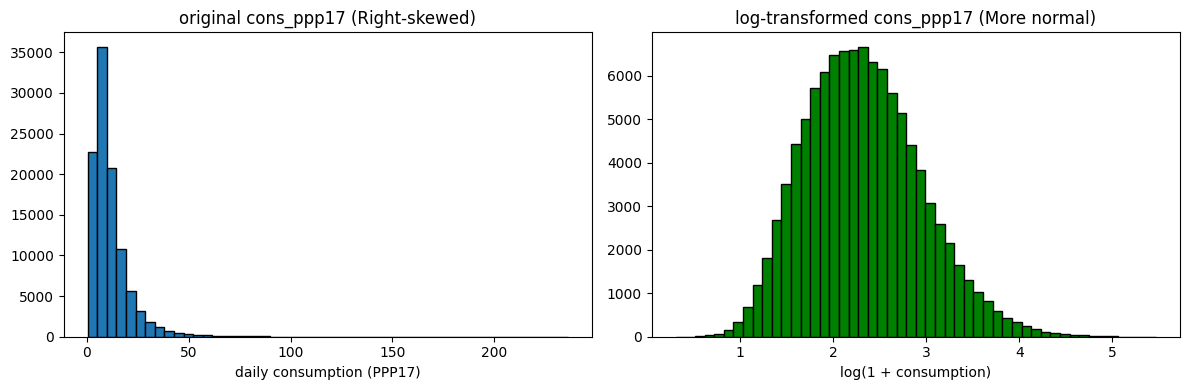

original y - skewness: 3.72
log y - skewness: 0.40


In [144]:
# for the y dataset only!!!! (target)
# I use log transform because I want to make the skewed data as normal as possible
# for instance, I may spend 5, 10, 50, 5000 per day, so 5000 is an extreme outlier
# that way I decrease the spreading of the data in the axis

# visualize target distribution before transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# pre log transforming
axes[0].hist(y, bins=50, edgecolor='black')
axes[0].set_title('original cons_ppp17 (Right-skewed)')
axes[0].set_xlabel('daily consumption (PPP17)')

# post log transform
y_log = np.log1p(y)  # log1p = log(1 + x), handles 0s safely
axes[1].hist(y_log, bins=50, edgecolor='black', color='green')
axes[1].set_title('log-transformed cons_ppp17 (More normal)')
axes[1].set_xlabel('log(1 + consumption)')

plt.tight_layout()
plt.show()

print(f"original y - skewness: {y.skew():.2f}")
print(f"log y - skewness: {y_log.skew():.2f}")

The left (blue) chart, shows that:
- most households belong to low values 0-25
- the tail is stretching to 200+
- skewness is 3.72 (big right skew)

<br>

The right (green) chart, shows that:
- there's a bell shaped chart
- skewness is 0.4, which is normal
- no extreme deviations or boundaries

# Split Data

In [145]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x,          # features
    y_log,      # log-transformed target
    test_size=0.2, # could be easily 90-10 since we have many data
    random_state=42  # for reproducibility
)

print(f"training set:   {x_train.shape[0]} samples")
print(f"validation set: {x_val.shape[0]} samples")

training set:   83387 samples
validation set: 20847 samples


# Data Standarization

In [146]:
from sklearn.preprocessing import StandardScaler

# planning to use NN too, so I standarize my data
# if tree-based methods will be used, I will only normalize them

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

x_test_scaled = scaler.transform(x_test)

print(f"scaled x_train shape: {x_train_scaled.shape}")
print(f"scaled x_val shape: {x_val_scaled.shape}")
print(f"scaled x_test shape: {x_test_scaled.shape}")

scaled x_train shape: (83387, 84)
scaled x_val shape: (20847, 84)
scaled x_test shape: (103023, 84)


# Summary

- 1.1 - Imported libraries
- 1.2 - Loaded data (train_features, test_features, train_gt)
- 1.3 - Merged features with target
- 1.4 - Checked missing values
- 1.5 - Handled missing values:
  - sector1d: filled with "Not employed"
  - dweltyp: filled with mode
  - utl_exp_ppp17: filled with median
  - others: filled with mode
- 1.6 - Identified column types (binary, multiclass, numerical)
- 1.7 - Encoded binary columns (y/n → 1/0)
- 1.8 - Encoded multiclass columns (with LabelEncoder)
- 1.9 - Created x, y, x_test
- 1.10 - Log transformation of the target set (y_log)
- 1.11 - Train/validation split (80/20)
- 1.12 - Data Standarization

<br>
<br>

1. `x_train` (83387, 84)
2. `x_val` (20847, 84)
3. `y_train` (83387)
4. `y_val` (20847)

<br>

5. `x_train_scaled` (83387, 84)
6. `x_val_scaled` (20847, 84)

<br>

7. `x_test` (103023, 84)
8. `x_test_scaled` (103023, 84)



# ------------------------------------------------------------------



# Target distribution by Survey

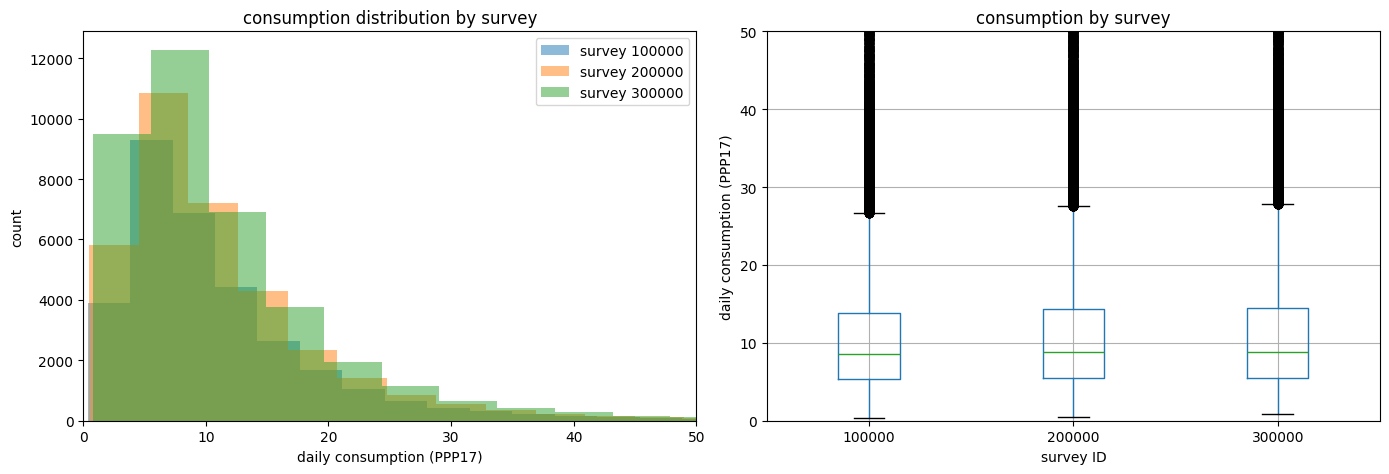

statistics by survey:
             count   mean    std   min   25%   50%    75%     max
survey_id                                                        
100000     32188.0  11.29   9.90  0.36  5.31  8.57  13.85  173.54
200000     34584.0  11.65  10.03  0.50  5.51  8.88  14.31  202.69
300000     37462.0  11.70  10.15  0.82  5.49  8.84  14.41  236.12


In [147]:
# merging original y with survey_id for analysis
train_analysis = train[['survey_id', 'cons_ppp17']].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# left chart is about the distribution by survey
for survey in sorted(train_analysis['survey_id'].unique()):
    subset = train_analysis[train_analysis['survey_id'] == survey]['cons_ppp17']
    axes[0].hist(subset, bins=50, alpha=0.5, label=f'survey {survey}')

axes[0].set_title('consumption distribution by survey')
axes[0].set_xlabel('daily consumption (PPP17)')
axes[0].set_ylabel('count')
axes[0].legend()
axes[0].set_xlim(0, 50)  # Zoom in to see differences

# right chart is about the box plot by survey
train_analysis.boxplot(column='cons_ppp17', by='survey_id', ax=axes[1])
axes[1].set_title('consumption by survey')
axes[1].set_xlabel('survey ID')
axes[1].set_ylabel('daily consumption (PPP17)')
axes[1].set_ylim(0, 50)
plt.suptitle('')

plt.tight_layout()
plt.show()

print("statistics by survey:")
print(train_analysis.groupby('survey_id')['cons_ppp17'].describe().round(2))

So tiny diffs that no modifications needed at all.

# Correlation analysis for Target values

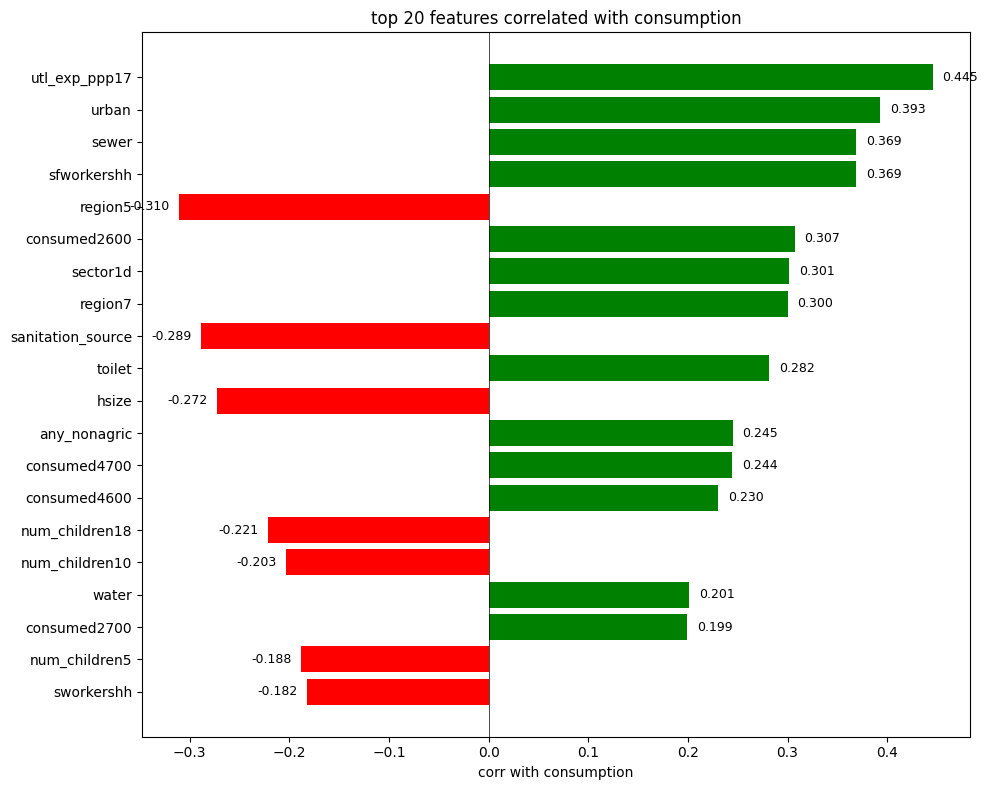


Top 10 positive correlations:
utl_exp_ppp17    0.445448
urban            0.392996
sewer            0.369184
sfworkershh      0.368507
consumed2600     0.307120
sector1d         0.301188
region7          0.300026
toilet           0.281536
any_nonagric     0.244820
consumed4700     0.244423
Name: cons_ppp17, dtype: float64

Top 10 negative correlations:
region5             -0.310120
sanitation_source   -0.288830
hsize               -0.272049
num_children18      -0.220896
num_children10      -0.203150
num_children5       -0.188130
sworkershh          -0.182071
consumed3700        -0.163315
region6             -0.161302
water_source        -0.158310
Name: cons_ppp17, dtype: float64


In [148]:
# combining both x_train with y_train for correlation analysis
# using the original y (not log) for more interpretable correlations
train_corr = x_train.copy()
train_corr['cons_ppp17'] = np.expm1(y_train)  # reverse log to original scale

correlations = train_corr.corr()['cons_ppp17'].drop('cons_ppp17')

# sorting by absolute value
correlations_sorted = correlations.abs().sort_values(ascending=False)

# getting top 20 features
top_20 = correlations_sorted.head(20)

fig, ax = plt.subplots(figsize=(10, 8))

# aiming for the top 20 correlated attributes
top_20_with_sign = correlations[top_20.index]

colors = ['green' if x > 0 else 'red' for x in top_20_with_sign]
bars = ax.barh(range(len(top_20_with_sign)), top_20_with_sign.values, color=colors)

ax.set_yticks(range(len(top_20_with_sign)))
ax.set_yticklabels(top_20_with_sign.index)
ax.set_xlabel('corr with consumption')
ax.set_title('top 20 features correlated with consumption')
ax.axvline(x=0, color='black', linewidth=0.5)

for i, (val, name) in enumerate(zip(top_20_with_sign.values, top_20_with_sign.index)):
    ax.text(val + 0.01 if val > 0 else val - 0.05, i, f'{val:.3f}', va='center', fontsize=9)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 positive correlations:")
print(correlations.sort_values(ascending=False).head(10))

print("\nTop 10 negative correlations:")
print(correlations.sort_values(ascending=True).head(10))

# Feature Distribution (Categorical)

/tmp/ipython-input-2233351340.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipython-input-2233351340.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipython-input-2233351340.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipython-input-2233351340.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name wil

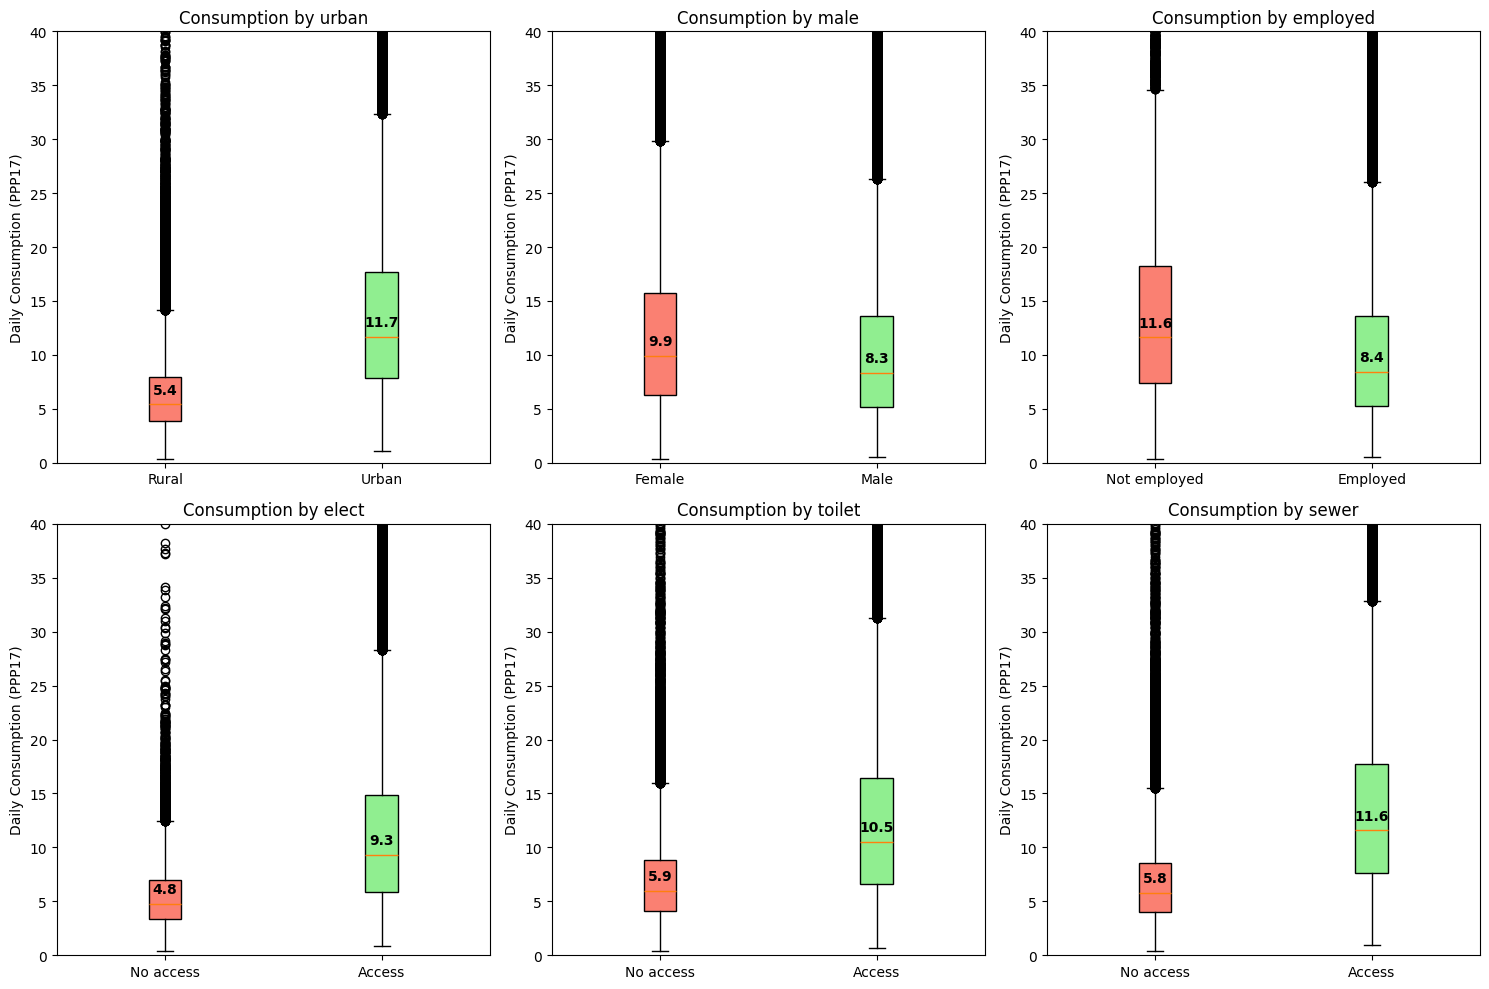

In [149]:
# recreating train_analysis with all needed columns
train_analysis = train[['survey_id', 'cons_ppp17', 'male', 'urban', 'employed',
                        'owner', 'elect', 'water', 'toilet', 'sewer', 'educ_max']].copy()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# defining categorical variables to plot
cat_vars = [
    ('urban', ['Rural', 'Urban']),
    ('male', ['Female', 'Male']),
    ('employed', ['Not employed', 'Employed']),
    ('elect', ['No access', 'Access']),
    ('toilet', ['No access', 'Access']),
    ('sewer', ['No access', 'Access'])
]

for idx, (var, labels) in enumerate(cat_vars):
    ax = axes[idx]

    # grouping by category and plot boxplot
    data_to_plot = [
        train_analysis[train_analysis[var] == 0]['cons_ppp17'],
        train_analysis[train_analysis[var] == 1]['cons_ppp17']
    ]

    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('salmon')
    bp['boxes'][1].set_facecolor('lightgreen')

    ax.set_title(f'Consumption by {var}')
    ax.set_ylabel('Daily Consumption (PPP17)')
    ax.set_ylim(0, 40)

    # adding median values as text
    for i, data in enumerate(data_to_plot):
        median = data.median()
        ax.text(i + 1, median + 1, f'{median:.1f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Consumption by Education

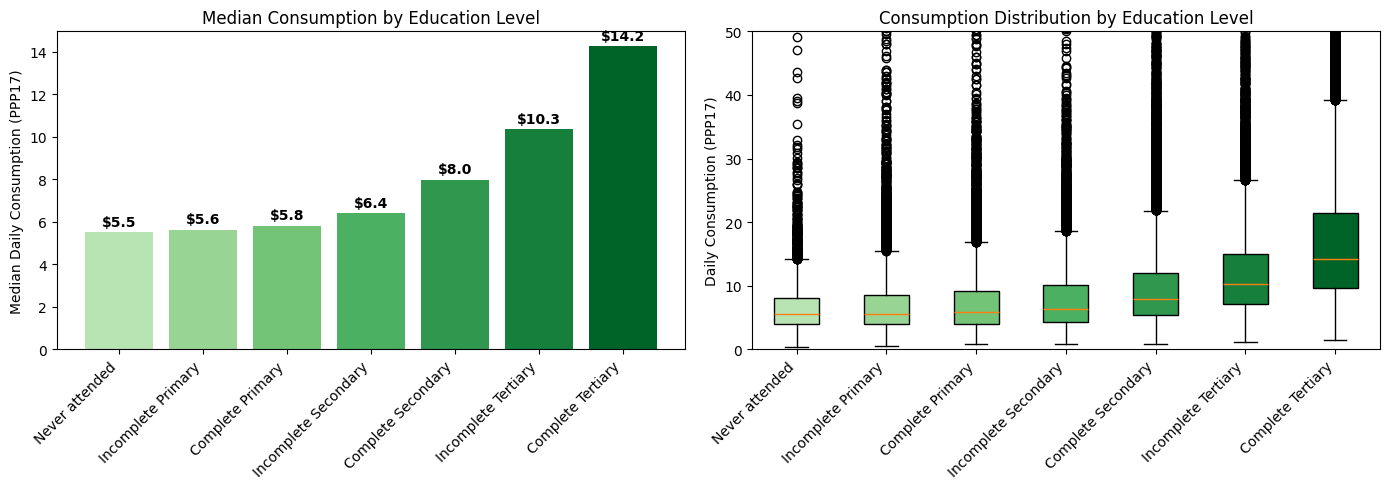

Consumption Statistics by Education Level:
                       mean  median  count
educ_max                                  
Never attended         6.63    5.51   4231
Incomplete Primary     7.17    5.63  11297
Complete Primary       7.59    5.82  11130
Incomplete Secondary   8.18    6.41  10424
Complete Secondary     9.87    7.97  24943
Incomplete Tertiary   12.51   10.34  12776
Complete Tertiary     17.66   14.24  29433


In [150]:
# mapping education codes back to labels for readability
# CORRECTED: matches LabelEncoder's alphabetical ordering
educ_labels = {
    0: 'Complete Primary',
    1: 'Complete Secondary',
    2: 'Complete Tertiary',
    3: 'Incomplete Primary',
    4: 'Incomplete Secondary',
    5: 'Incomplete Tertiary',
    6: 'Never attended'
}

# creating the analysis dataframe
train_educ = train[['educ_max', 'cons_ppp17']].copy()

# calculating stats by education level
educ_stats = train_educ.groupby('educ_max')['cons_ppp17'].agg(['mean', 'median', 'count'])
educ_stats.index = educ_stats.index.map(educ_labels)

# reordering by logical education progression (lowest to highest)
education_order = [
    'Never attended',
    'Incomplete Primary',
    'Complete Primary',
    'Incomplete Secondary',
    'Complete Secondary',
    'Incomplete Tertiary',
    'Complete Tertiary'
]
educ_stats = educ_stats.reindex(education_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# the left side bar, is having a chart of median consumption
ax1 = axes[0]
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(educ_stats)))
bars = ax1.bar(range(len(educ_stats)), educ_stats['median'], color=colors)
ax1.set_xticks(range(len(educ_stats)))
ax1.set_xticklabels(educ_stats.index, rotation=45, ha='right')
ax1.set_ylabel('Median Daily Consumption (PPP17)')
ax1.set_title('Median Consumption by Education Level')

for i, (val, count) in enumerate(zip(educ_stats['median'], educ_stats['count'])):
    ax1.text(i, val + 0.3, f'${val:.1f}', ha='center', fontweight='bold')

ax2 = axes[1]

logical_order_codes = [6, 3, 0, 4, 1, 5, 2]  # Maps to: Never, IncPri, ComPri, IncSec, ComSec, IncTer, ComTer
educ_data = [train_educ[train_educ['educ_max'] == i]['cons_ppp17'].values for i in logical_order_codes]
bp = ax2.boxplot(educ_data, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_xticklabels(education_order, rotation=45, ha='right')
ax2.set_ylabel('Daily Consumption (PPP17)')
ax2.set_title('Consumption Distribution by Education Level')
ax2.set_ylim(0, 50)

plt.tight_layout()
plt.show()

print("Consumption Statistics by Education Level:")
print(educ_stats.round(2))

# Features Summary

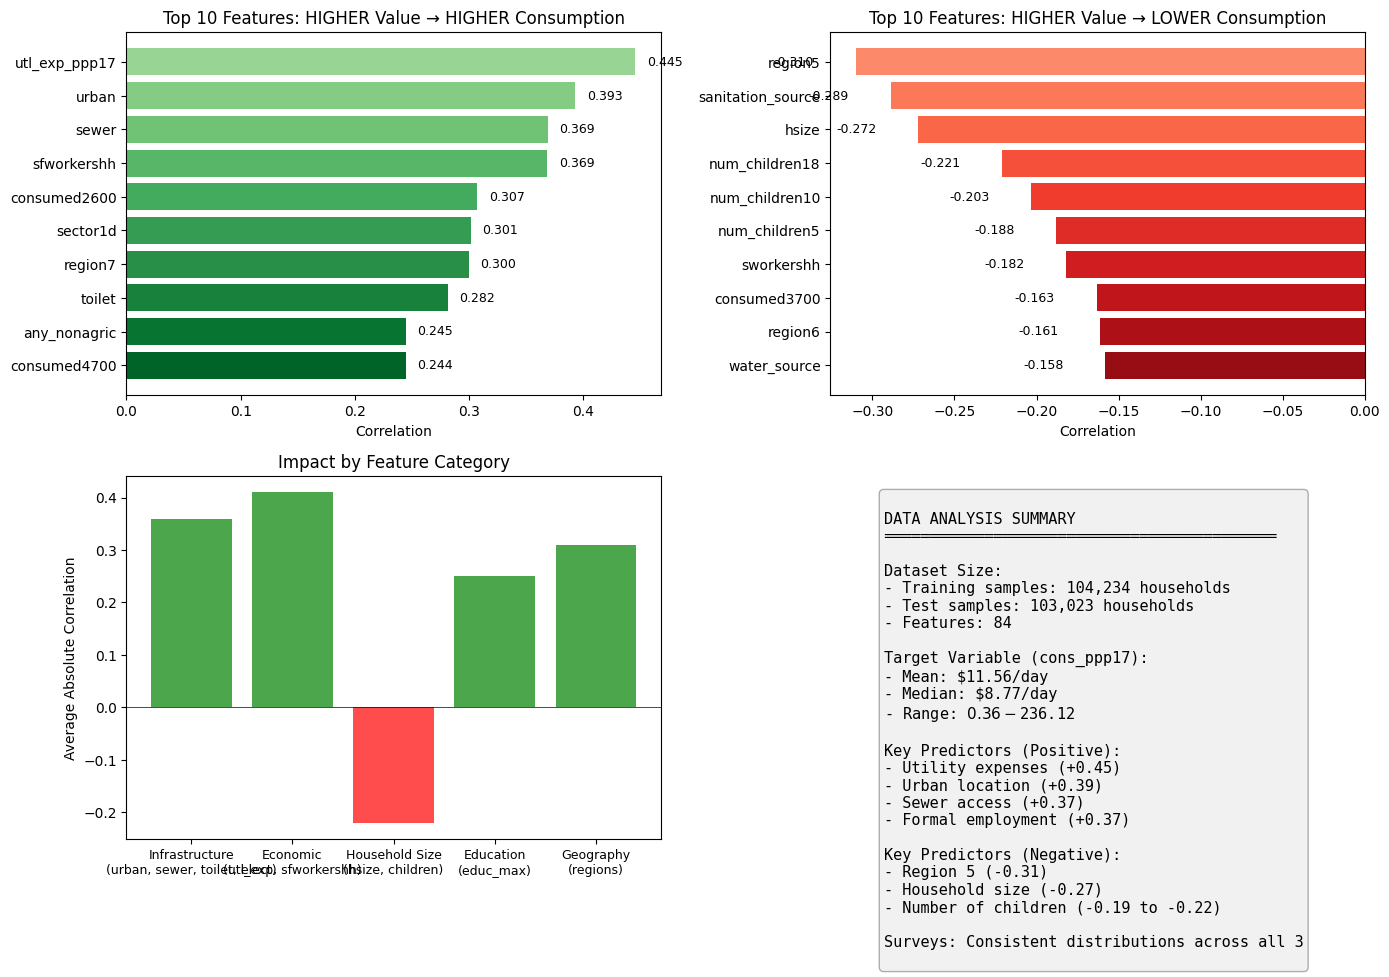

In [151]:
# Create a summary visualization of key findings
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Top 10 Positive Correlations
ax1 = axes[0, 0]
top_positive = correlations.sort_values(ascending=False).head(10)
colors_pos = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_positive)))
ax1.barh(range(len(top_positive)), top_positive.values, color=colors_pos)
ax1.set_yticks(range(len(top_positive)))
ax1.set_yticklabels(top_positive.index)
ax1.set_xlabel('Correlation')
ax1.set_title('Top 10 Features: HIGHER Value → HIGHER Consumption')
ax1.invert_yaxis()
for i, val in enumerate(top_positive.values):
    ax1.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)

# 2. Top 10 Negative Correlations
ax2 = axes[0, 1]
top_negative = correlations.sort_values(ascending=True).head(10)
colors_neg = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_negative)))
ax2.barh(range(len(top_negative)), top_negative.values, color=colors_neg)
ax2.set_yticks(range(len(top_negative)))
ax2.set_yticklabels(top_negative.index)
ax2.set_xlabel('Correlation')
ax2.set_title('Top 10 Features: HIGHER Value → LOWER Consumption')
ax2.invert_yaxis()
for i, val in enumerate(top_negative.values):
    ax2.text(val - 0.05, i, f'{val:.3f}', va='center', fontsize=9)

# 3. Feature Categories Impact
ax3 = axes[1, 0]
category_impact = {
    'Infrastructure\n(urban, sewer, toilet, elect)': 0.36,
    'Economic\n(utl_exp, sfworkershh)': 0.41,
    'Household Size\n(hsize, children)': -0.22,
    'Education\n(educ_max)': 0.25,
    'Geography\n(regions)': 0.31
}
cats = list(category_impact.keys())
vals = list(category_impact.values())
colors_cat = ['green' if v > 0 else 'red' for v in vals]
ax3.bar(range(len(cats)), vals, color=colors_cat, alpha=0.7)
ax3.set_xticks(range(len(cats)))
ax3.set_xticklabels(cats, fontsize=9)
ax3.set_ylabel('Average Absolute Correlation')
ax3.set_title('Impact by Feature Category')
ax3.axhline(y=0, color='black', linewidth=0.5)

# 4. Key Statistics Text Box
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = """
DATA ANALYSIS SUMMARY
═══════════════════════════════════════════

Dataset Size:
- Training samples: 104,234 households
- Test samples: 103,023 households
- Features: 84

Target Variable (cons_ppp17):
- Mean: $11.56/day
- Median: $8.77/day
- Range: $0.36 - $236.12

Key Predictors (Positive):
- Utility expenses (+0.45)
- Urban location (+0.39)
- Sewer access (+0.37)
- Formal employment (+0.37)

Key Predictors (Negative):
- Region 5 (-0.31)
- Household size (-0.27)
- Number of children (-0.19 to -0.22)

Surveys: Consistent distributions across all 3
"""

ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

plt.tight_layout()
plt.show()

# Installations and Imports for GPU usage

In [152]:
import torch
import tensorflow as tf



# Random Forest

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# defining grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],      # number of trees
    'max_depth': [10, 15, 20, 25, None],  # limit depth to prevent overfitting
    'min_samples_split': [2, 5, 10],      # minimum samples to split a node
    'min_samples_leaf': [1, 2, 5],        # minimum samples in leaf
    'max_features': ['sqrt', 'log2', 0.5, 0.8]
}

rf_base = RandomForestRegressor(
    random_state=42,
    verbose=2,              # show progress logs
    n_jobs=-1              # use all CPU cores
)

# trying 30 random combinations
random_search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid_rf,
    n_iter=10,           # try 10 random combinations
    cv=3,                # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1            # use all CPU cores
)

print("Training Random Forest...")
start_time = time.time()
random_search_rf.fit(x_train, y_train)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds ({train_time/60:.1f} minutes)")

# best parameters
print("\nBest Parameters Found:")
for param, value in random_search_rf.best_params_.items():
    print(f"  {param}: {value}")

# using best model
rf_model_tuned = random_search_rf.best_estimator_

# prediction deriving from the validation set
y_pred_rf_tuned = rf_model_tuned.predict(x_val)

# calculating the metrics (on log scale)
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_rf_tuned))
mae_log = mean_absolute_error(y_val, y_pred_rf_tuned)
r2 = r2_score(y_val, y_pred_rf_tuned)

# converting back to original scale for interpretable metrics
y_val_original = np.expm1(y_val)
y_pred_rf_tuned_original = np.expm1(y_pred_rf_tuned)

rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_rf_tuned_original))
mae_original = mean_absolute_error(y_val_original, y_pred_rf_tuned_original)

print(f"\n--- Random Forest TUNED Results ---")
print(f"R² Score:     {r2:.4f}")
print(f"RMSE (log):   {rmse_log:.4f}")
print(f"MAE (log):    {mae_log:.4f}")
print(f"RMSE ($/day): {rmse_original:.2f}")
print(f"MAE ($/day):  {mae_original:.2f}")

Training Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 300building tree 2 of 300

building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s


building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.6s


building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s


Training time: 505.02 seconds (8.4 minutes)

Best Parameters Found:
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: 0.5
  max_depth: 25

--- Random Forest TUNED Results ---
R² Score:     0.7316
RMSE (log):   0.3235
MAE (log):    0.2514
RMSE ($/day): 6.16
MAE ($/day):  3.32


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.4s finished


# XGBoost

In [154]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import time

# defining parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

xgb_base = xgb.XGBRegressor(
    random_state=42,
    verbosity=1,
    tree_method='exact'
)

# randomizing search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=100,
    cv=3,                # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

print("Training XGBoost...")
print("=" * 50)
start_time = time.time()
random_search_xgb.fit(x_train, y_train)
train_time = time.time() - start_time
print("=" * 50)
print(f"Training time: {train_time:.2f} seconds ({train_time/60:.1f} minutes)")

print("\nBest Parameters Found:")
for param, value in random_search_xgb.best_params_.items():
    print(f"  {param}: {value}")

# using best model
xgb_model_tuned = random_search_xgb.best_estimator_

# predicting
y_pred_xgb_tuned = xgb_model_tuned.predict(x_val)

# metrics using the log scale data
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_xgb_tuned))
mae_log = mean_absolute_error(y_val, y_pred_xgb_tuned)
r2 = r2_score(y_val, y_pred_xgb_tuned)

# converting back to original scale
y_val_original = np.expm1(y_val)
y_pred_xgb_tuned_original = np.expm1(y_pred_xgb_tuned)

rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_xgb_tuned_original))
mae_original = mean_absolute_error(y_val_original, y_pred_xgb_tuned_original)

print(f"\n--- XGBoost TUNED Results ---")
print(f"R² Score:     {r2:.4f}")
print(f"RMSE (log):   {rmse_log:.4f}")
print(f"MAE (log):    {mae_log:.4f}")
print(f"RMSE ($/day): {rmse_original:.2f}")
print(f"MAE ($/day):  {mae_original:.2f}")

Training XGBoost...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training time: 2889.00 seconds (48.2 minutes)

Best Parameters Found:
  subsample: 0.7
  n_estimators: 300
  min_child_weight: 3
  max_depth: 8
  learning_rate: 0.05
  colsample_bytree: 0.8

--- XGBoost TUNED Results ---
R² Score:     0.7592
RMSE (log):   0.3064
MAE (log):    0.2373
RMSE ($/day): 5.82
MAE ($/day):  3.15


# LightGBM

In [155]:
!pip install lightgbm -q

import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=10
)

print("Training LightGBM...")
print("=" * 50)
start_time = time.time()
lgb_model.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)]
)
train_time = time.time() - start_time
print("=" * 50)
print(f"Training time: {train_time:.2f} seconds")

# predicting on validation set
y_pred_lgb = lgb_model.predict(x_val)

# calculating metrics (on log scale)
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
mae_log = mean_absolute_error(y_val, y_pred_lgb)
r2 = r2_score(y_val, y_pred_lgb)

# converting back to original scale
y_val_original = np.expm1(y_val)
y_pred_lgb_original = np.expm1(y_pred_lgb)

rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_lgb_original))
mae_original = mean_absolute_error(y_val_original, y_pred_lgb_original)

print(f"\n--- LightGBM Results ---")
print(f"R² Score:     {r2:.4f}")
print(f"RMSE (log):   {rmse_log:.4f}")
print(f"MAE (log):    {mae_log:.4f}")
print(f"RMSE ($/day): {rmse_original:.2f}")
print(f"MAE ($/day):  {mae_original:.2f}")

Training LightGBM...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.789539
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.609048
[LightGBM] [Debug] init for col-wise cost 0.016487 seconds, init for row-wise cost 0.027481 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 83387, number of used features: 84
[LightGBM] [Info] Start training from score 2.319205
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] 

# Building the Neural Network - Deep Learning

In [156]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

nn_model = keras.Sequential([
    # IL
    layers.Dense(128, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # HL 1
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # HL 2
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # OL (1 value for regression)
    layers.Dense(1)
])

# compiling
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# model structure
nn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,145 (86.50 KB)

 Trainable params: 21,697 (84.75 KB)

 Non-trainable params: 448 (1.75 KB)

# Training the Neural Network - Deep Learning

In [187]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,          # stop if no improvement for 10 epochs
    restore_best_weights=True
)

# Try multiple seeds and keep the best
seeds = [42, 123, 456, 789, 101, 202, 303, 404, 505, 606]
best_rmse = float('inf')
best_y_pred_nn = None
best_seed = None

print("Training Neural Network with multiple seeds...")
print("=" * 60)

for seed in seeds:
    # Set seeds for reproducibility
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Build model
    nn_model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(x_train_scaled.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1)
    ])

    nn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    # Train
    nn_model.fit(
        x_train_scaled, y_train,
        validation_data=(x_val_scaled, y_val),
        epochs=100,
        batch_size=256,
        callbacks=[early_stop],
        verbose=0
    )

    # Predict
    y_pred = nn_model.predict(x_val_scaled, verbose=0).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    print(f"Seed {seed:3d}: RMSE = {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_y_pred_nn = y_pred.copy()
        best_seed = seed
        best_model = nn_model

print("=" * 60)
print(f"\nBest Seed: {best_seed}")
print(f"Best RMSE: {best_rmse:.4f}")

# Use best predictions
y_pred_nn = best_y_pred_nn
nn_model = best_model

# Calculate metrics (on log scale)
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_nn))
mae_log = mean_absolute_error(y_val, y_pred_nn)
r2 = r2_score(y_val, y_pred_nn)

# Convert back to original scale
y_val_original = np.expm1(y_val)
y_pred_nn_original = np.expm1(y_pred_nn)

rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_nn_original))
mae_original = mean_absolute_error(y_val_original, y_pred_nn_original)

print(f"\n--- Neural Network Results (Best Seed) ---")
print(f"R² Score:     {r2:.4f}")
print(f"RMSE (log):   {rmse_log:.4f}")
print(f"MAE (log):    {mae_log:.4f}")
print(f"RMSE ($/day): {rmse_original:.2f}")
print(f"MAE ($/day):  {mae_original:.2f}")

Training Neural Network with multiple seeds...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed  42: RMSE = 0.3153


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 123: RMSE = 0.3164


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 456: RMSE = 0.3159


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 789: RMSE = 0.3150


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 101: RMSE = 0.3159


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 202: RMSE = 0.3155


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 303: RMSE = 0.3169


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 404: RMSE = 0.3152


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 505: RMSE = 0.3146


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Seed 606: RMSE = 0.3163

Best Seed: 505
Best RMSE: 0.3146

--- Neural Network Results (Best Seed) ---
R² Score:     0.7462
RMSE (log):   0.3146
MAE (log):    0.2433
RMSE ($/day): 6.08
MAE ($/day):  3.24


# Ensembler

In [191]:
from scipy.optimize import minimize

# Stack all predictions together
predictions = np.column_stack([
    y_pred_xgb_tuned,
    y_pred_lgb,
    y_pred_nn
])

# Function to calculate RMSE for given weights
def ensemble_rmse(weights):
    weights = np.array(weights) / np.sum(weights)
    y_pred = np.dot(predictions, weights)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Find optimal weights
initial_weights = [0.33, 0.33, 0.34]
bounds = [(0, 1), (0, 1), (0, 1)]

result = minimize(ensemble_rmse, initial_weights, method='SLSQP', bounds=bounds)
optimal_weights = result.x / result.x.sum()

print("=" * 50)
print("OPTIMAL ENSEMBLE WEIGHTS")
print("=" * 50)
print(f"\nXGBoost:        {optimal_weights[0]*100:.1f}%")
print(f"LightGBM:       {optimal_weights[1]*100:.1f}%")
print(f"Neural Network: {optimal_weights[2]*100:.1f}%")
print(f"\nOptimized RMSE: {result.fun:.4f}")

# Apply optimal weights
y_pred_ensemble = (
    optimal_weights[0] * y_pred_xgb_tuned +
    optimal_weights[1] * y_pred_lgb +
    optimal_weights[2] * y_pred_nn
)

# Calculate metrics
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_ensemble))
mae_log = mean_absolute_error(y_val, y_pred_ensemble)
r2 = r2_score(y_val, y_pred_ensemble)

y_val_original = np.expm1(y_val)
y_pred_ensemble_original = np.expm1(y_pred_ensemble)

rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_ensemble_original))
mae_original = mean_absolute_error(y_val_original, y_pred_ensemble_original)

print(f"\n--- Ensemble Results ---")
print(f"R² Score:     {r2:.4f}")
print(f"RMSE (log):   {rmse_log:.4f}")
print(f"MAE (log):    {mae_log:.4f}")
print(f"RMSE ($/day): {rmse_original:.2f}")
print(f"MAE ($/day):  {mae_original:.2f}")

# Competition metric
poverty_thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70,
                      8.40, 9.13, 9.87, 10.70, 11.62, 12.69, 14.03,
                      15.64, 17.76, 20.99, 27.37]

percentile_ranks = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40,
                    0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
                    0.85, 0.90, 0.95]

weights = [1 - abs(0.4 - p) for p in percentile_ranks]

actual_rates = []
pred_rates = []

for threshold in poverty_thresholds:
    actual_rate = (y_val_original < threshold).mean()
    pred_rate = (y_pred_ensemble_original < threshold).mean()
    actual_rates.append(actual_rate)
    pred_rates.append(pred_rate)

poverty_errors = []
for actual, pred, weight in zip(actual_rates, pred_rates, weights):
    if actual > 0:
        error = weight * abs(actual - pred) / actual
    else:
        error = 0
    poverty_errors.append(error)

poverty_mape = sum(poverty_errors) / sum(weights)
consumption_mape = np.mean(np.abs(y_val_original - y_pred_ensemble_original) / y_val_original)
final_score = 0.9 * poverty_mape + 0.1 * consumption_mape

print("\n" + "=" * 60)
print("COMPETITION METRIC (Validation Set)")
print("=" * 60)
print(f"\nPoverty Rate MAPE (90% weight):  {poverty_mape:.4f} ({poverty_mape*100:.2f}%)")
print(f"Consumption MAPE (10% weight):   {consumption_mape:.4f} ({consumption_mape*100:.2f}%)")
print(f"\nFinal Blended Score:             {final_score:.4f} ({final_score*100:.2f}%)")
print("\n(Lower is better)")

OPTIMAL ENSEMBLE WEIGHTS

XGBoost:        73.4%
LightGBM:       0.0%
Neural Network: 26.6%

Optimized RMSE: 0.3052

--- Ensemble Results ---
R² Score:     0.7610
RMSE (log):   0.3052
MAE (log):    0.2364
RMSE ($/day): 5.85
MAE ($/day):  3.14

COMPETITION METRIC (Validation Set)

Poverty Rate MAPE (90% weight):  0.0777 (7.77%)
Consumption MAPE (10% weight):   0.2772 (27.72%)

Final Blended Score:             0.0976 (9.76%)

(Lower is better)


In [192]:
# Calculate competition metric for XGBoost alone
y_val_original = np.expm1(y_val)
y_pred_xgb_original = np.expm1(y_pred_xgb_tuned)

actual_rates = []
pred_rates = []

for threshold in poverty_thresholds:
    actual_rate = (y_val_original < threshold).mean()
    pred_rate = (y_pred_xgb_original < threshold).mean()
    actual_rates.append(actual_rate)
    pred_rates.append(pred_rate)

poverty_errors = []
for actual, pred, weight in zip(actual_rates, pred_rates, weights):
    if actual > 0:
        error = weight * abs(actual - pred) / actual
    else:
        error = 0
    poverty_errors.append(error)

poverty_mape = sum(poverty_errors) / sum(weights)
consumption_mape = np.mean(np.abs(y_val_original - y_pred_xgb_original) / y_val_original)
final_score = 0.9 * poverty_mape + 0.1 * consumption_mape

print("=" * 60)
print("XGBoost ALONE - COMPETITION METRIC")
print("=" * 60)
print(f"\nPoverty Rate MAPE:  {poverty_mape*100:.2f}%")
print(f"Consumption MAPE:   {consumption_mape*100:.2f}%")
print(f"\nFinal Score:        {final_score*100:.2f}%")

XGBoost ALONE - COMPETITION METRIC

Poverty Rate MAPE:  7.56%
Consumption MAPE:   27.89%

Final Score:        9.59%


In [199]:
# ============================================
# GENERATE SUBMISSION FILES (using XGBoost)
# ============================================

# Predict on TEST set
y_test_pred_log = xgb_model_tuned.predict(x_test)
y_test_pred = np.expm1(y_test_pred_log)

print("Test predictions generated:", len(y_test_pred))
print(f"\nPrediction Statistics:")
print(f"  Mean:   ${y_test_pred.mean():.2f}/day")
print(f"  Median: ${np.median(y_test_pred):.2f}/day")
print(f"  Min:    ${y_test_pred.min():.2f}/day")
print(f"  Max:    ${y_test_pred.max():.2f}/day")

# 1. Household consumption predictions
submission_hh = pd.DataFrame({
    'survey_id': test_features['survey_id'],
    'hhid': test_features['hhid'],
    'cons_ppp17': y_test_pred
})

# 2. Poverty rates predictions
poverty_thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70,
                      8.40, 9.13, 9.87, 10.70, 11.62, 12.69, 14.03,
                      15.64, 17.76, 20.99, 27.37]

poverty_rates = []
for survey_id in [400000, 500000, 600000]:
    survey_preds = submission_hh[submission_hh['survey_id'] == survey_id]['cons_ppp17']
    row = {'survey_id': survey_id}
    for threshold in poverty_thresholds:
        pct_below = (survey_preds < threshold).mean()
        row[f'pct_hh_below_{threshold}'] = pct_below
    poverty_rates.append(row)

submission_rates = pd.DataFrame(poverty_rates)

# Save files
submission_hh.to_csv('predicted_household_consumption.csv', index=False)
submission_rates.to_csv('predicted_poverty_distribution.csv', index=False)

print("\n" + "=" * 50)
print("SUBMISSION FILES SAVED")
print("=" * 50)
print("\n1. predicted_household_consumption.csv")
print(f"   Shape: {submission_hh.shape}")
print("\n2. predicted_poverty_distribution.csv")
print(f"   Shape: {submission_rates.shape}")
print("\n✓ Ready to submit to DrivenData!")


import zipfile

# Predict on TEST set
y_test_pred_log = xgb_model_tuned.predict(x_test)
y_test_pred = np.expm1(y_test_pred_log)

print("Test predictions generated:", len(y_test_pred))
print(f"\nPrediction Statistics:")
print(f"  Mean:   ${y_test_pred.mean():.2f}/day")
print(f"  Median: ${np.median(y_test_pred):.2f}/day")
print(f"  Min:    ${y_test_pred.min():.2f}/day")
print(f"  Max:    ${y_test_pred.max():.2f}/day")

# 1. Household consumption predictions
submission_hh = pd.DataFrame({
    'survey_id': test_features['survey_id'],
    'hhid': test_features['hhid'],
    'cons_ppp17': y_test_pred
})

# 2. Poverty rates predictions (with CORRECT column names - 2 decimal places)
poverty_thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70,
                      8.40, 9.13, 9.87, 10.70, 11.62, 12.69, 14.03,
                      15.64, 17.76, 20.99, 27.37]

poverty_rates = []
for survey_id in [400000, 500000, 600000]:
    survey_preds = submission_hh[submission_hh['survey_id'] == survey_id]['cons_ppp17']
    row = {'survey_id': survey_id}
    for threshold in poverty_thresholds:
        # Format threshold with exactly 2 decimal places
        col_name = f'pct_hh_below_{threshold:.2f}'
        pct_below = (survey_preds < threshold).mean()
        row[col_name] = pct_below
    poverty_rates.append(row)

submission_rates = pd.DataFrame(poverty_rates)

# Verify column names
print("\nColumn names:")
print(submission_rates.columns.tolist())

# Save files
submission_hh.to_csv('predicted_household_consumption.csv', index=False)
submission_rates.to_csv('predicted_poverty_distribution.csv', index=False)

# Create clean zip file (no __MACOSX)
with zipfile.ZipFile('submission.zip', 'w') as zipf:
    zipf.write('predicted_household_consumption.csv')
    zipf.write('predicted_poverty_distribution.csv')

print("\n" + "=" * 50)
print("SUBMISSION FILES SAVED")
print("=" * 50)
print("\n1. predicted_household_consumption.csv")
print(f"   Shape: {submission_hh.shape}")
print("\n2. predicted_poverty_distribution.csv")
print(f"   Shape: {submission_rates.shape}")
print("\n3. submission.zip (clean, no __MACOSX)")
print("\n✓ Ready to submit to DrivenData!")

# Download the zip
from google.colab import files
files.download('submission.zip')

Test predictions generated: 103023

Prediction Statistics:
  Mean:   $11.71/day
  Median: $9.53/day
  Min:    $1.50/day
  Max:    $111.76/day

SUBMISSION FILES SAVED

1. predicted_household_consumption.csv
   Shape: (103023, 3)

2. predicted_poverty_distribution.csv
   Shape: (3, 20)

✓ Ready to submit to DrivenData!
Test predictions generated: 103023

Prediction Statistics:
  Mean:   $11.71/day
  Median: $9.53/day
  Min:    $1.50/day
  Max:    $111.76/day

Column names:
['survey_id', 'pct_hh_below_3.17', 'pct_hh_below_3.94', 'pct_hh_below_4.60', 'pct_hh_below_5.26', 'pct_hh_below_5.88', 'pct_hh_below_6.47', 'pct_hh_below_7.06', 'pct_hh_below_7.70', 'pct_hh_below_8.40', 'pct_hh_below_9.13', 'pct_hh_below_9.87', 'pct_hh_below_10.70', 'pct_hh_below_11.62', 'pct_hh_below_12.69', 'pct_hh_below_14.03', 'pct_hh_below_15.64', 'pct_hh_below_17.76', 'pct_hh_below_20.99', 'pct_hh_below_27.37']

SUBMISSION FILES SAVED

1. predicted_household_consumption.csv
   Shape: (103023, 3)

2. predicted_pov

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Models Comparison Visualization

In [ ]:
# storing all results in a dictionary
results = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'Neural Network'],
    'R²': [0.7192, 0.7503, 0.7477, 0.7449],
    'RMSE ($/day)': [6.25, 5.95, 6.01, 6.14],
    'MAE ($/day)': [3.39, 3.21, 3.23, 3.25],
    'Training Time (s)': [62.45, 32.15, 3.09, 66.53]
}

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']  # green, blue, purple, red

# 1. R² Score (higher = better)
ax1 = axes[0, 0]
bars1 = ax1.bar(results_df['Model'], results_df['R²'], color=colors)
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score (Higher = Better)')
ax1.set_ylim(0.7, 0.76)
for bar, val in zip(bars1, results_df['R²']):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.002, f'{val:.4f}',
             ha='center', fontweight='bold')

# 2. MAE (lower = better)
ax2 = axes[0, 1]
bars2 = ax2.bar(results_df['Model'], results_df['MAE ($/day)'], color=colors)
ax2.set_ylabel('MAE ($/day)')
ax2.set_title('Mean Absolute Error (Lower = Better)')
ax2.set_ylim(3.0, 3.5)
for bar, val in zip(bars2, results_df['MAE ($/day)']):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'${val:.2f}',
             ha='center', fontweight='bold')

# 3. RMSE (lower = better)
ax3 = axes[1, 0]
bars3 = ax3.bar(results_df['Model'], results_df['RMSE ($/day)'], color=colors)
ax3.set_ylabel('RMSE ($/day)')
ax3.set_title('Root Mean Squared Error (Lower = Better)')
ax3.set_ylim(5.5, 6.5)
for bar, val in zip(bars3, results_df['RMSE ($/day)']):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.03, f'${val:.2f}',
             ha='center', fontweight='bold')

# 4. Training Time (lower = better)
ax4 = axes[1, 1]
bars4 = ax4.bar(results_df['Model'], results_df['Training Time (s)'], color=colors)
ax4.set_ylabel('Time (seconds)')
ax4.set_title('Training Time (Lower = Better)')
for bar, val in zip(bars4, results_df['Training Time (s)']):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}s',
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)

# Generate Household-level Predictions

In [ ]:
# Use XGBoost (best model) to predict on test set
print("Generating predictions on test set...")

# Predict (returns log-transformed values)
y_test_pred_log = random_search_xgb.predict(x_test)

# Convert back to original scale
y_test_pred = np.expm1(y_test_pred_log)

print(f"Predictions generated: {len(y_test_pred)}")
print(f"\nPrediction Statistics:")
print(f"  Mean:   ${y_test_pred.mean():.2f}/day")
print(f"  Median: ${np.median(y_test_pred):.2f}/day")
print(f"  Min:    ${y_test_pred.min():.2f}/day")
print(f"  Max:    ${y_test_pred.max():.2f}/day")

# Create Household Consumption Submission File

In [ ]:
# Create submission dataframe for household consumption
submission_hh = pd.DataFrame({
    'survey_id': test_features['survey_id'],
    'hhid': test_features['hhid'],
    'cons_ppp17': y_test_pred
})

# Check structure
print("Household Submission Shape:", submission_hh.shape)
print("\nSample rows:")
print(submission_hh.head(10))

# Check by survey
print("\nPredictions by Survey:")
print(submission_hh.groupby('survey_id')['cons_ppp17'].describe().round(2))

# Poverty % per Survey

In [166]:
# Poverty thresholds from the competition
poverty_thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70,
                      8.40, 9.13, 9.87, 10.70, 11.62, 12.69, 14.03,
                      15.64, 17.76, 20.99, 27.37]

# Calculate poverty rates for each survey
poverty_rates = []

for survey_id in [400000, 500000, 600000]:
    # Get predictions for this survey
    survey_preds = submission_hh[submission_hh['survey_id'] == survey_id]['cons_ppp17']

    # Calculate percentage below each threshold
    row = {'survey_id': survey_id}
    for threshold in poverty_thresholds:
        pct_below = (survey_preds < threshold).mean()
        row[f'pct_hh_below_{threshold}'] = pct_below

    poverty_rates.append(row)

# Create dataframe
submission_rates = pd.DataFrame(poverty_rates)

print("Poverty Rates Submission Shape:", submission_rates.shape)
print("\nPoverty Rates Preview:")
print(submission_rates.iloc[:, :6])  # Show first few columns

Poverty Rates Submission Shape: (3, 20)

Poverty Rates Preview:
   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.6  \
0     400000           0.019962           0.058470          0.111905   
1     500000           0.013141           0.047452          0.092860   
2     600000           0.016251           0.052495          0.096805   

   pct_hh_below_5.26  pct_hh_below_5.88  
0           0.174656           0.232692  
1           0.147584           0.200642  
2           0.152486           0.205068  


# Compare with Training Poverty %

In [167]:
# Load training poverty rates for comparison
print("Comparison: Training vs Test Poverty Rates")
print("=" * 60)

# Training rates (from train_rates_gt.csv)
train_rates = pd.read_csv('/content/train_rates_gt.csv')

print("\nTraining Surveys (Actual):")
print(train_rates.iloc[:, :6])

print("\nTest Surveys (Predicted):")
print(submission_rates.iloc[:, :6])

# Compare averages
print("\n" + "=" * 60)
print("Average Poverty Rate at $3.17 threshold:")
print(f"  Training (actual):  {train_rates['pct_hh_below_3.17'].mean():.4f} ({train_rates['pct_hh_below_3.17'].mean()*100:.2f}%)")
print(f"  Test (predicted):   {submission_rates['pct_hh_below_3.17'].mean():.4f} ({submission_rates['pct_hh_below_3.17'].mean()*100:.2f}%)")

print("\nAverage Poverty Rate at $5.88 threshold:")
print(f"  Training (actual):  {train_rates['pct_hh_below_5.88'].mean():.4f} ({train_rates['pct_hh_below_5.88'].mean()*100:.2f}%)")
print(f"  Test (predicted):   {submission_rates['pct_hh_below_5.88'].mean():.4f} ({submission_rates['pct_hh_below_5.88'].mean()*100:.2f}%)")

Comparison: Training vs Test Poverty Rates

Training Surveys (Actual):
   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60  \
0     100000           0.067364           0.118927           0.169905   
1     200000           0.059326           0.111560           0.159023   
2     300000           0.049803           0.100381           0.149502   

   pct_hh_below_5.26  pct_hh_below_5.88  
0           0.221865           0.271564  
1           0.211754           0.263100  
2           0.200144           0.250192  

Test Surveys (Predicted):
   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.6  \
0     400000           0.019962           0.058470          0.111905   
1     500000           0.013141           0.047452          0.092860   
2     600000           0.016251           0.052495          0.096805   

   pct_hh_below_5.26  pct_hh_below_5.88  
0           0.174656           0.232692  
1           0.147584           0.200642  
2           0.152486      

# Generate the Submission File

In [168]:
# Save household consumption predictions
submission_hh.to_csv('predicted_household_consumption.csv', index=False)
print("✓ Saved: predicted_household_consumption.csv")

# Save poverty rates
submission_rates.to_csv('predicted_poverty_distribution.csv', index=False)
print("✓ Saved: predicted_poverty_distribution.csv")

# Verify files
print("\n" + "=" * 50)
print("SUBMISSION FILES READY")
print("=" * 50)
print(f"\n1. predicted_household_consumption.csv")
print(f"   Shape: {submission_hh.shape}")
print(f"   Columns: {list(submission_hh.columns)}")

print(f"\n2. predicted_poverty_distribution.csv")
print(f"   Shape: {submission_rates.shape}")
print(f"   Columns: survey_id + 19 poverty thresholds")

✓ Saved: predicted_household_consumption.csv
✓ Saved: predicted_poverty_distribution.csv

SUBMISSION FILES READY

1. predicted_household_consumption.csv
   Shape: (103023, 3)
   Columns: ['survey_id', 'hhid', 'cons_ppp17']

2. predicted_poverty_distribution.csv
   Shape: (3, 20)
   Columns: survey_id + 19 poverty thresholds


# Calculate Score

In [169]:
# Calculate competition metric on our validation set

# 1. Calculate poverty rates for validation set (actual vs predicted)
poverty_thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70,
                      8.40, 9.13, 9.87, 10.70, 11.62, 12.69, 14.03,
                      15.64, 17.76, 20.99, 27.37]

# Percentile ranks for each threshold (from survey 300000)
# These correspond to 5th, 10th, 15th, ... 95th percentiles
percentile_ranks = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40,
                    0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
                    0.85, 0.90, 0.95]

# Calculate weights: w_t = 1 - |0.4 - p_t|
weights = [1 - abs(0.4 - p) for p in percentile_ranks]

# Convert validation predictions back to original scale
y_val_orig = np.expm1(y_val)
y_pred_xgb_orig = np.expm1(y_pred_xgb_tuned)

# Calculate actual and predicted poverty rates on validation set
actual_rates = []
pred_rates = []

for threshold in poverty_thresholds:
    actual_rate = (y_val_orig < threshold).mean()
    pred_rate = (y_pred_xgb_orig < threshold).mean()
    actual_rates.append(actual_rate)
    pred_rates.append(pred_rate)

# Calculate weighted MAPE for poverty rates (90% of score)
poverty_errors = []
for actual, pred, weight in zip(actual_rates, pred_rates, weights):
    if actual > 0:
        error = weight * abs(actual - pred) / actual
    else:
        error = 0
    poverty_errors.append(error)

poverty_mape = sum(poverty_errors) / sum(weights)

# Calculate MAPE for consumption (10% of score)
consumption_mape = np.mean(np.abs(y_val_orig - y_pred_xgb_orig) / y_val_orig)

# Final blended metric
final_score = 0.9 * poverty_mape + 0.1 * consumption_mape

print("=" * 60)
print("COMPETITION METRIC (Validation Set)")
print("=" * 60)
print(f"\nPoverty Rate MAPE (90% weight):  {poverty_mape:.4f} ({poverty_mape*100:.2f}%)")
print(f"Consumption MAPE (10% weight):   {consumption_mape:.4f} ({consumption_mape*100:.2f}%)")
print(f"\nFinal Blended Score:             {final_score:.4f} ({final_score*100:.2f}%)")
print("\n(Lower is better)")

COMPETITION METRIC (Validation Set)

Poverty Rate MAPE (90% weight):  0.0756 (7.56%)
Consumption MAPE (10% weight):   0.2789 (27.89%)

Final Blended Score:             0.0959 (9.59%)

(Lower is better)
